# Target mask for adversarial example

In [1]:
%load_ext autoreload
%autoreload 2
# imports
import copy
import datetime
import logging
import os
import sys

import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

from loss_functions import final_stage_heat_loss, multi_stage_loss
from plot_utils import gen_plot, plot_human_lines, plot_pose
from tf_pose import common
from tf_pose.common import CocoPart
from tf_pose.estimator import PoseEstimator, TfPoseEstimator
from tf_pose.networks import get_graph_path
from utils import print_image_Stats, compare_poses, get_humans_as_lines


sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)

/home/ax/miniconda3/envs/masterThesis/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Using tf version = 1.15.0


In [3]:
# params 432, 368
w, h = 432, 368
image_path_source = '../data/images/dri_source_2.jpg'
image_path_source_mask = '../data/images/dri_source_2_mask_body.jpg'
image_path_target = '../data/images/dri_target_far_2.jpg'
model = 'cmu'
log_dir = '../logs/'
resize_out_ratio = 2.0
image_source = common.read_imgfile(image_path_source, w, h)
image_target = common.read_imgfile(image_path_target, w, h)
image_source_mask = common.read_imgfile(
    image_path_source_mask, w, h, cv2.IMREAD_GRAYSCALE) > 0

summary_writer = tf.summary.FileWriter(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [4]:
e_source = TfPoseEstimator(get_graph_path(
    model), target_size=(w, h), trt_bool=False)
e_target = TfPoseEstimator(get_graph_path(
    model), target_size=(w, h), trt_bool=False)
upsample_size = [int(e_target.target_size[1] / 8 * resize_out_ratio),
                 int(e_target.target_size[0] / 8 * resize_out_ratio)]

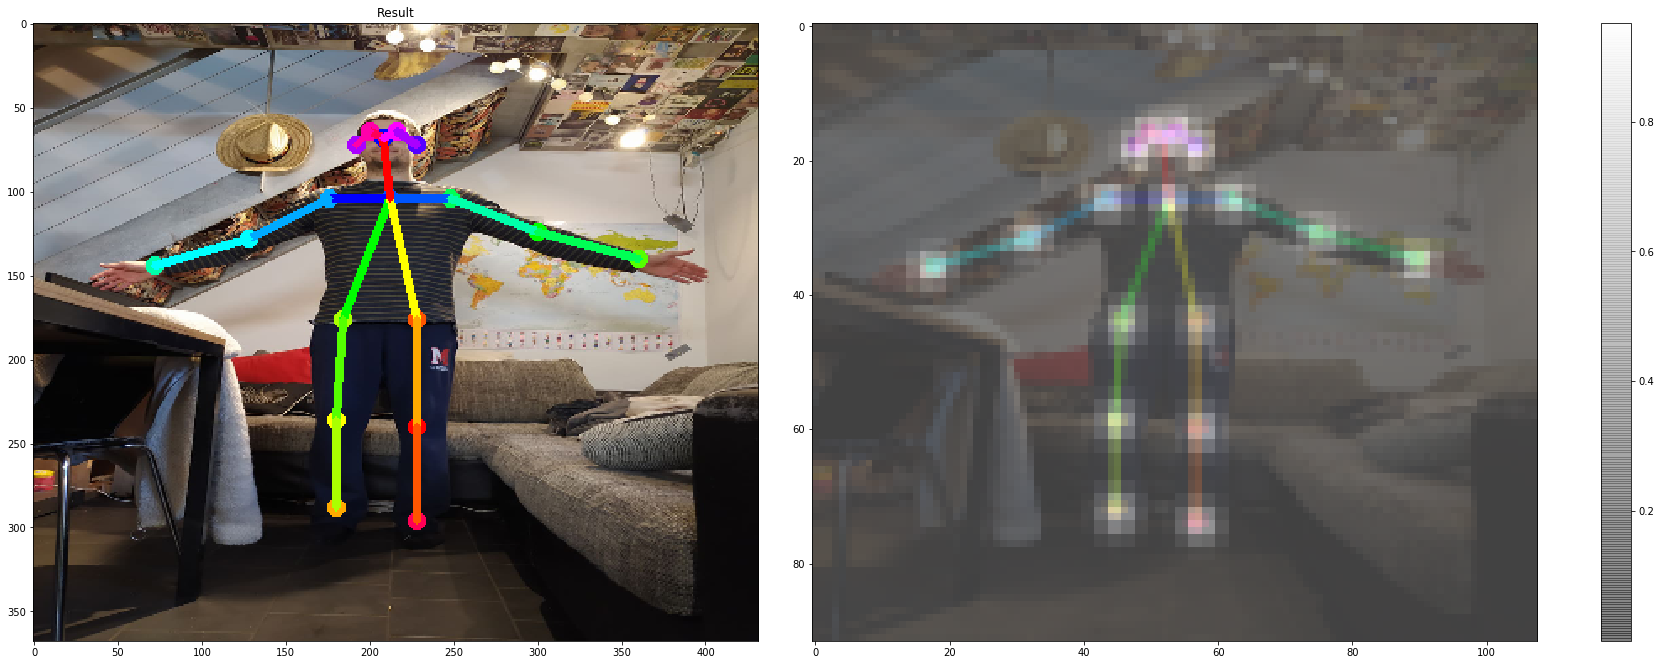

In [5]:
human_source = e_source.inference(image_source, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_source, human_source, e_source.heatMat)

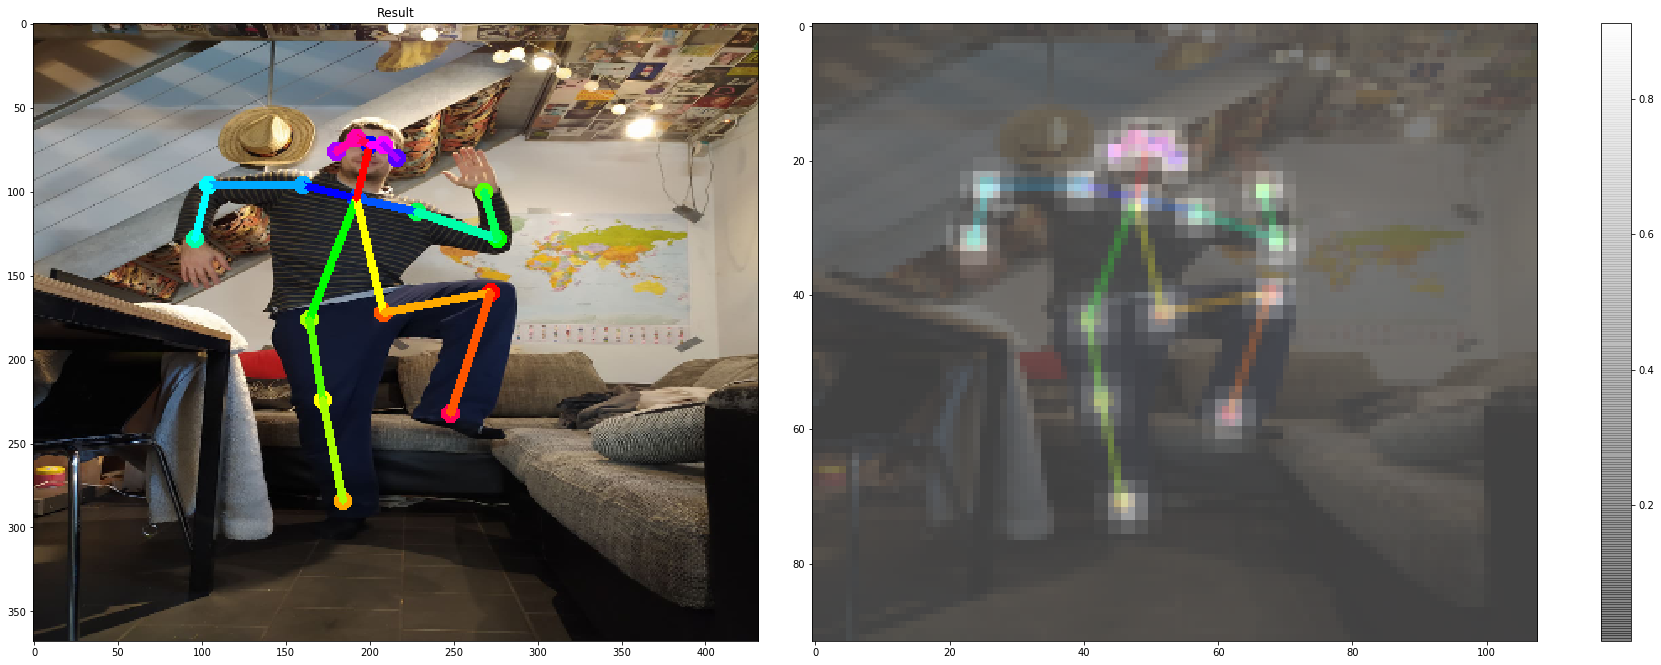

In [6]:
human_target = e_target.inference(image_target, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, e_target.heatMat)

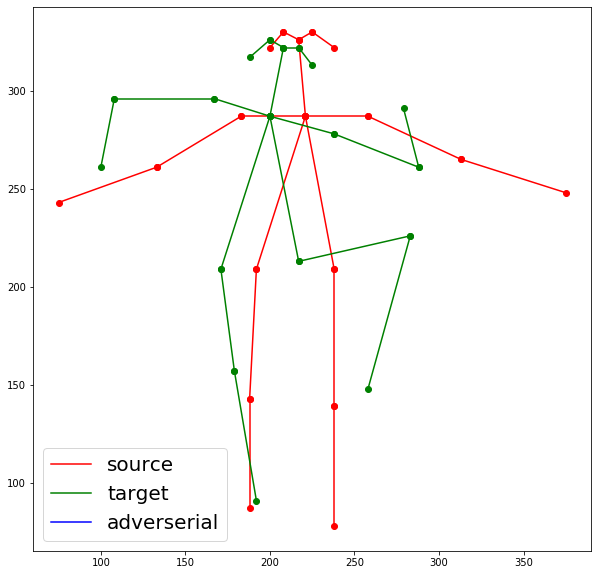

In [7]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [8]:
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = e_target.persistent_sess.run(
    [e_target.tensor_output, e_target.tensor_heatMat_up,
        e_target.tensor_pafMat_up, e_target.tensor_peaks],
    feed_dict={
        e_target.tensor_image: [image_target],
        e_target.upsample_size: upsample_size
    }
)

source_np, source_np_heat, source_np_paf, source_np_peaks = e_source.persistent_sess.run(
    [e_source.tensor_output, e_source.tensor_heatMat_up,
        e_source.tensor_pafMat_up, e_source.tensor_peaks],
    feed_dict={
        e_source.tensor_image: [image_source],
        e_source.upsample_size: upsample_size
    }
)

(1, 46, 54, 57)
(1, 92, 108, 19)
(1, 92, 108, 38)
(1, 92, 108, 19)


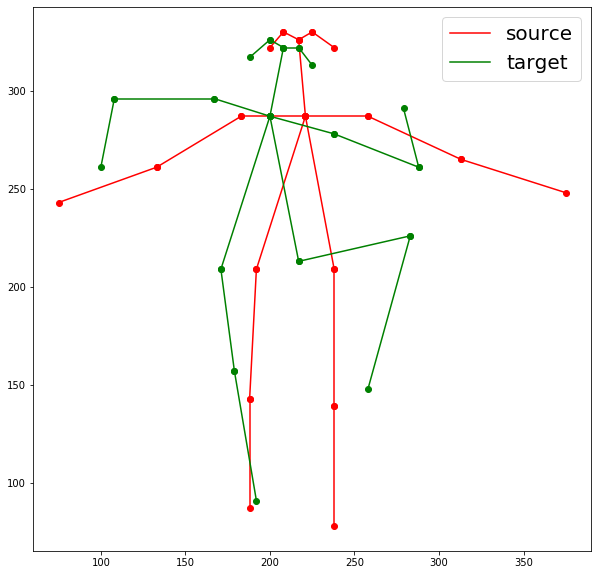

In [9]:
print(target_np.shape)
print(target_np_heat.shape)
print(target_np_paf.shape)
print(target_np_peaks.shape)

# for i in range(52):
#     print(np.sum(np.abs(target_np[:, :, :, i] - source_np[:, :, :, i])))


human_source = PoseEstimator.estimate_paf(
    source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(
    target_np_peaks[0], target_np_heat[0], target_np_paf[0])


source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

100%|██████████| 20/20 [02:40<00:00,  8.02s/it]


Min: 0
Max: 255
Avg: 88.26177536231884
Min: 0.0
Max: 255.0
Avg: 89.57067108154297
Poses have different length of body parts
The total diff is 0 and the part moved the most is the NONE


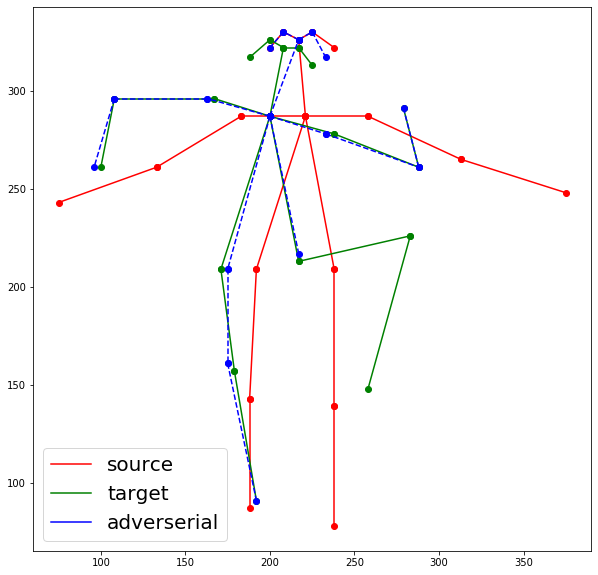

In [15]:
EPS = 5000
STEPS = 20
STAGE_INDEX = 6  # range from 2 to 6
ONLY_HEAT_MAP_AS_LOSS = False


if not "adv_image" in vars():
    adv_image = copy.deepcopy(image_source)
target_heat, grad_func, loss_func = [None, None, None]

human_source = PoseEstimator.estimate_paf(
    source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(
    target_np_peaks[0], target_np_heat[0], target_np_paf[0])


if ONLY_HEAT_MAP_AS_LOSS:
    target_heat = tf.compat.v1.placeholder(
        tf.float32, shape=(None, None, None, 19))
    grad_func, loss_func = final_stage_heat_loss(e_source, target_heat)
else:

    target_heat = tf.compat.v1.placeholder(
        tf.float32, shape=(None, None, None, 19))
    target_paf = tf.compat.v1.placeholder(
        tf.float32, shape=(None, None, None, 38))
    grad_func, loss_func = multi_stage_loss(
        e_source, target_heat, target_paf, STAGE_INDEX)

for i in tqdm(range(STEPS)):
    # compute gradient
    gradient, gn_summ = e_source.persistent_sess.run(
        [grad_func, loss_func],
        feed_dict={
            target_heat: target_np[:, :, :, CocoPart.RWrist.value] if ONLY_HEAT_MAP_AS_LOSS else target_np[:, :, :, :19],
            target_paf: target_np[:, :, :, 19:],
            e_source.tensor_image: [adv_image],
            e_source.upsample_size: upsample_size
        }
    )
    summary_writer.add_summary(gn_summ, i)
    if i % 20 == 0:
        human_adv = e_source.inference(adv_image, resize_to_default=(
            w > 0 and h > 0), upsample_size=resize_out_ratio)
        # Prepare the plot
        plot_buf = gen_plot(human_source, human_target, human_adv)

        # Convert PNG buffer to TF image
        tf_image = tf.image.decode_png(plot_buf.getvalue(), channels=4)

        # Add the batch dimension
        tf_image = tf.expand_dims(tf_image, 0)

        # Add image summary
        summary_op = tf.summary.image(f"poses_step{i}", tf_image)
        summary_img = e_source.persistent_sess.run(summary_op)
        # Write summary

        summary_writer.add_summary(summary_img)
        summary_writer.flush()

    ### ================= UPDATE STEP ================= ###
    #adv_image = adv_image - EPS * np.sign(gradient[0])
    scaled_gradient = image_source_mask[..., None] * (EPS * gradient[0])
    adv_image = adv_image - scaled_gradient
    adv_image = np.clip(adv_image, 0, 255)

summary_writer.flush()

human_adv = e_source.inference(adv_image, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)

print_image_Stats(image_source)
print_image_Stats(adv_image)
total_diff, most_moved_part = compare_poses(human_source[0], human_adv[0])
print(
    f'The total diff is {total_diff} and the part moved the most is the {most_moved_part}')

2020-03-20 13:28:47,187 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 368, 432, 3)
Min: -0.0075106630101799965
Max: 0.007735916879028082
Avg: 8.132128925808502e-08


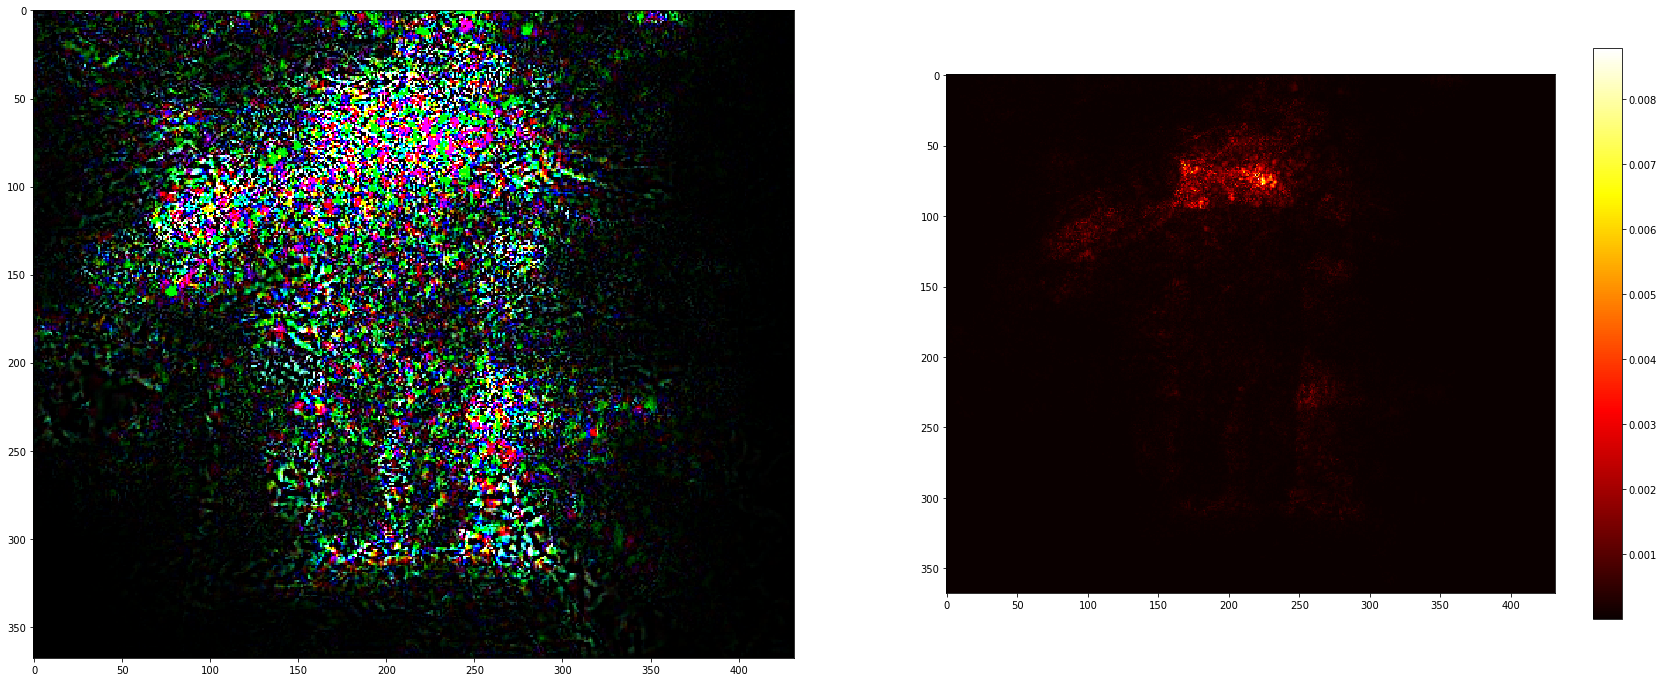

In [11]:
SCALE = 10000
print(gradient.shape)
print_image_Stats(gradient[0])
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(gradient[0] * SCALE)


grad_len = np.zeros((gradient[0].shape[:2]))
for y in range(gradient[0].shape[0]):
    for x in range(gradient[0].shape[1]):
        cur_vec = gradient[0, y, x]
        grad_len[y, x] = np.linalg.norm(cur_vec)

ax = fig.add_subplot(1, 2, 2)
heat_image = ax.imshow(grad_len, cmap='hot')
fig.colorbar(heat_image, ax=ax, shrink=0.35)

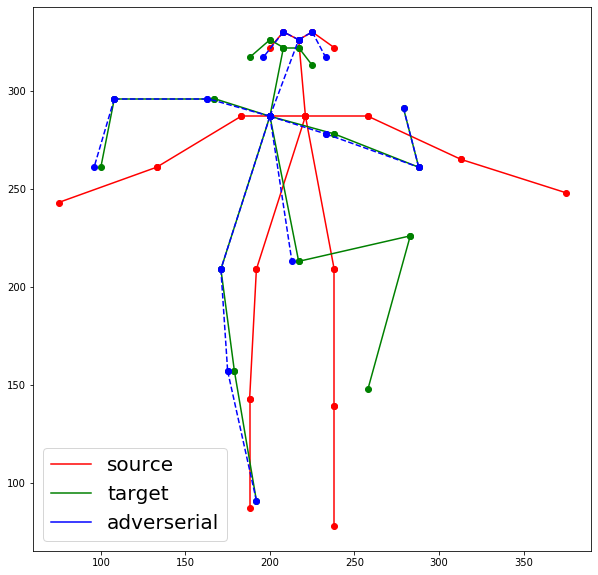

In [16]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)
adv_lines = get_humans_as_lines(human_adv, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')
plot_human_lines(adv_lines, ax, color='b', linestyle='--', label='adv')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

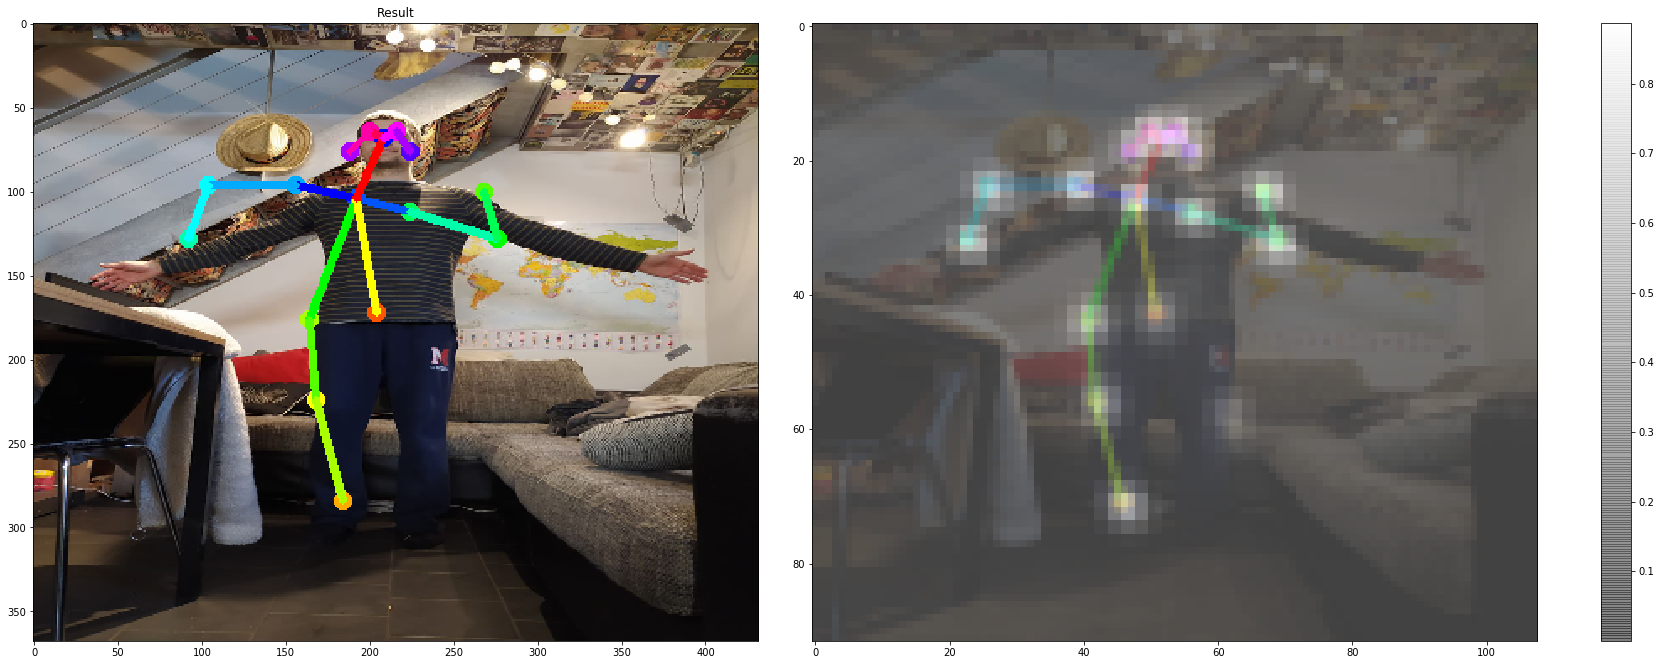

In [17]:
plot_pose(image_source, human_adv, e_source.heatMat)

2020-03-20 13:33:36,557 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.1904761904761902


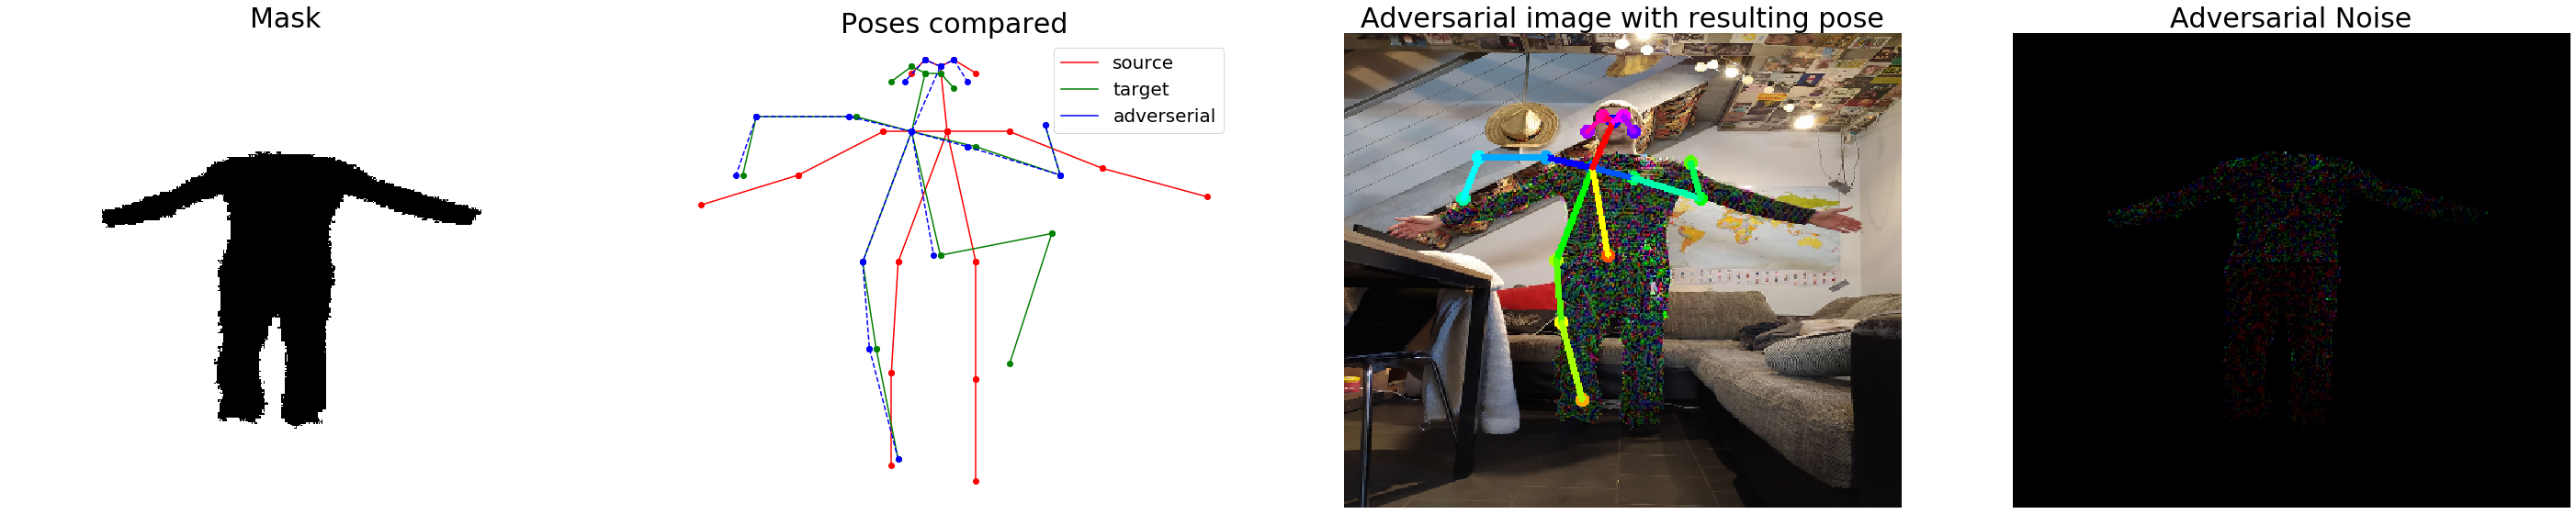

In [18]:
fig = plt.figure(figsize=(50, 25))

image_source_result = TfPoseEstimator.draw_humans(image_source, human_source, imgcopy=True)

ax = fig.add_subplot(1, 4, 1)
ax.imshow(image_source_mask, cmap='Greys')
ax.set_title('Mask', size=30)
ax.axis('off')

adv_image_cliped = np.clip(adv_image, 0, 255) 
image_adv_result = TfPoseEstimator.draw_humans(adv_image_cliped, human_adv, imgcopy=True)

ax = fig.add_subplot(1, 4, 2)
ax.set_title('Poses compared', size=30)
plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')
plot_human_lines(adv_lines, ax, color='b', linestyle='--', label='adv')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})
ax.axis('off')
asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
print(asp)
ax.set_aspect(asp - 0.2)


ax = fig.add_subplot(1, 4, 3)
ax.imshow(cv2.cvtColor(image_adv_result, cv2.COLOR_BGR2RGB) / 255.0)
ax.set_title('Adversarial image with resulting pose', size=30)
ax.axis('off')


ax = fig.add_subplot(1, 4, 4)
ax.set_title('Adversarial Noise', size=30)
noise = image_source - adv_image
ax.imshow(noise / 255.0)
ax.axis('off')
fig.savefig('../results/plots/single_image_adv_noise_mask.png', dpi=100, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(50, 25))
adv_image_cliped = np.clip(adv_image, 0, 255) / 255
ax = fig.add_subplot(1, 1, 1)
ax.imshow(cv2.cvtColor(adv_image_cliped, cv2.COLOR_BGR2RGB))
ax.set_title('Adversarial image')